# K's Reversal Indicators のデモ

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import talib as ta
import matplotlib.dates as mdates
from datetime import date, datetime, timedelta
import numpy as np
from pandas_datareader import data as pdr
import mplfinance as mpf
plt.style.use('fivethirtyeight')

## 株価データの取得

In [2]:
# 通貨ペアはマネーパートナーズのメニューに出てくるもののみ
list_ticker = ['USDJPY=X', 'EURJPY=X', 'GBPJPY=X', 'AUDJPY=X', 'CADJPY=X', 'NZDJPY=X', 'MXNJPY=X', 'CHFJPY=X', 'NOKJPY=X',\
               'ZARJPY=X', 'TRYJPY=X', 'ILSJPY=X',\
               'EURUSD=X', 'GBPUSD=X', 'AUDUSD=X', 'NZDUSD=X', 'AUDNZD=X', 'EURGBP=X', 'GBPAUD=X']

In [3]:
# Define the stock symbol and timeframe
# 現保有銘柄
symbol = 'USDJPN=X'
#symbol = '9984.T'
end_date = datetime.today()
start_date = end_date - timedelta(days=1095)
yf.pdr_override()
# yahooサイトからデータをダウンロード
data = pdr.get_data_yahoo(symbol, start_date, end_date)
data.tail()

[*********************100%%**********************]  1 of 1 completed


1 Failed download:
['USDJPN=X']: Exception('%ticker%: No timezone found, symbol may be delisted')


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,


## K's Reversal Indicator (I) 戦略の実装

In [4]:
def kr_1_strategy(df):
    kr_Buy = []
    kr_Sell = []
    df['bbub'],df['bbmb'],df['bblb'] = ta.BBANDS(df['Adj Close'], timeperiod=100, nbdevup=1.5, nbdevdn=1.5)
    df['macd'], df['macdsignal'], df['macdhist'] = ta.MACD(df['Adj Close'], fastperiod=12, slowperiod=26, signalperiod=9)

    for i in range(0, len(df)):
        if df['Adj Close'][i] <= df['bblb'][i] and df['macd'][i-1] <= df['macdsignal'][i-1] \
           and df['macd'][i] > df['macdsignal'][i]:
            kr_Sell.append(np.nan)
            kr_Buy.append(df['Adj Close'][i])
        elif df['Adj Close'][i] >= df['bbub'][i] and df['macd'][i-1] >= df['macdsignal'][i-1] \
           and df['macd'][i] < df['macdsignal'][i]:
            kr_Buy.append(np.nan)
            kr_Sell.append(df['Adj Close'][i])        
        else:
            kr_Buy.append(np.nan)
            kr_Sell.append(np.nan)

    df['kr_Buy_Signal_price'] = kr_Buy
    df['kr_Sell_Signal_price'] = kr_Sell
    return df

In [5]:
df1 = data.copy()
df1 = kr_1_strategy(df1)
df1

,Open,High,Low,Close,Adj Close,Volume,bbub,bbmb,bblb,macd,macdsignal,macdhist,kr_Buy_Signal_price,kr_Sell_Signal_price
Date,,,,,,,,,,,,,,


## K's Reversal Indicator (I) 戦略の図示

C:\Users\user\AppData\Local\Temp\ipykernel_8252\899310412.py:4: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)


TypeError: ufunc 'isfinite' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

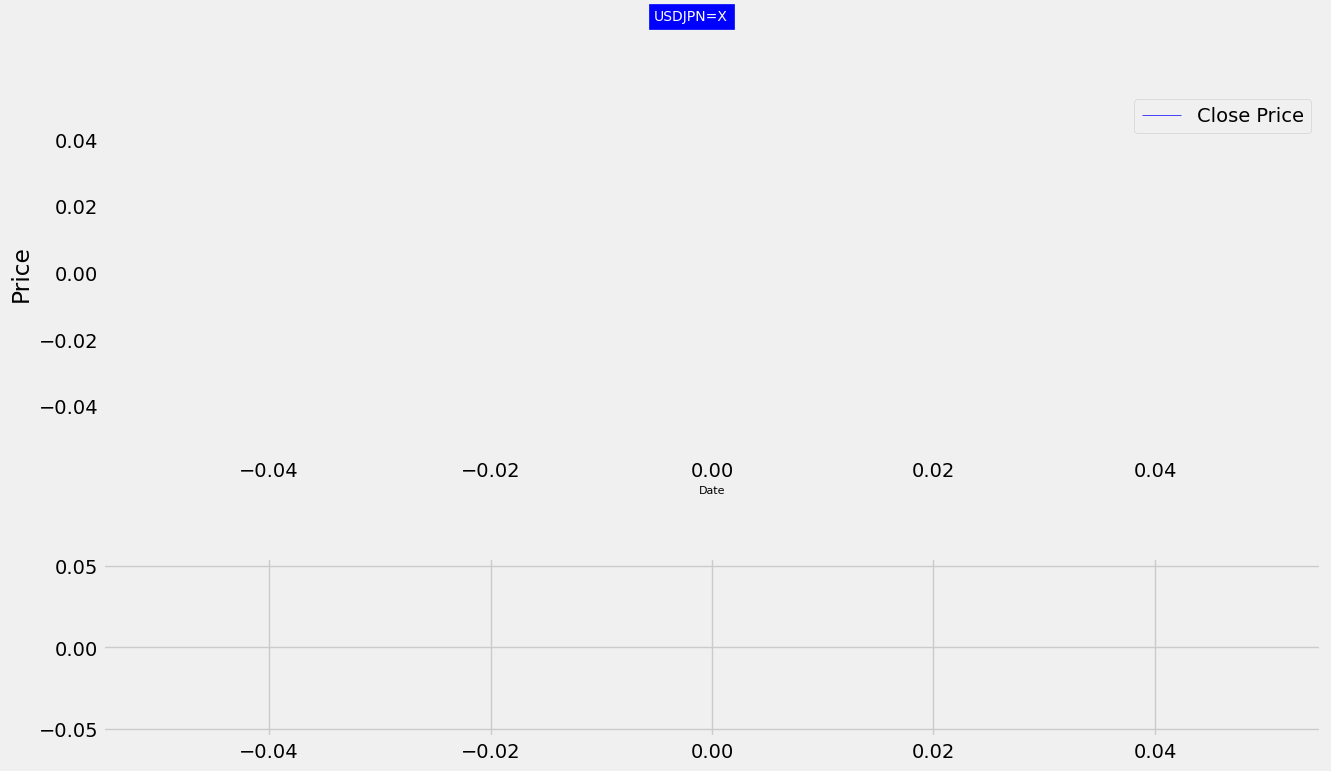

In [6]:
#plot
fig, ax1 = plt.subplots(figsize=(14,8))
fig.suptitle(symbol, fontsize=10, backgroundcolor='blue', color='white')
ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
ax2 = plt.subplot2grid((14, 12), (10, 0), rowspan=6, colspan=14)
ax1.set_ylabel('Price')
ax1.plot(df1['Adj Close'],label='Close Price', linewidth=0.5, color='blue')
ax1.scatter(df1.index, df1['kr_Buy_Signal_price'], color='green', marker='^', alpha=1)
ax1.scatter(df1.index, df1['kr_Sell_Signal_price'], color='red', marker='v', alpha=1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('Date', fontsize=8)

ax2.plot(df1['Adj Close'], label='Close', color='blue', alpha=0.35) #middle band
ax2.plot(df1['bbub'], label='Upper', color='green', alpha=0.35) #Upper band
ax2.plot(df1['bblb'], label='Lower', color='red', alpha=0.35) #lower band
ax2.fill_between(df1.index, df1['bbub'], df1['bblb'], alpha=0.1)
ax2.legend(loc='upper left')
ax2.grid()
plt.show()

In [ ]:
df1[['kr_Buy_Signal_price','kr_Sell_Signal_price']].tail(1)

## K's Reversal Indicator (III) 戦略の実装

In [ ]:
# 直近部分系列の相関係数の計算関数
def ser_corr(x, y, timeperiod=20):
    rcoef = np.full_like(x, np.nan)
    for i in range(timeperiod - 1, len(x)):
        xx = x[i-timeperiod+1 : i+1]
        yy = y[i-timeperiod+1 : i+1]
        rcoef[i] = np.corrcoef(xx, yy)[0, 1]
    return rcoef

In [ ]:
def kr_3_strategy(df):
    kr_Buy = []
    kr_Sell = []
    df['return1'] = df['Adj Close'].diff(1)
    df['return14'] = df['Adj Close'].diff(14)
    df['rtcorr'] = ser_corr(df['return1'], df['return14'], timeperiod=14)
    df['RSI'] = ta.RSI(df['Adj Close'], timeperiod=14)

    for i in range(0, len(df)):
        if df['rtcorr'][i] > 0.6 and df['RSI'][i] < 40:
            kr_Sell.append(np.nan)
            kr_Buy.append(df['Adj Close'][i])
        elif df['rtcorr'][i] > 0.6 and df['RSI'][i] > 60:
            kr_Buy.append(np.nan)
            kr_Sell.append(df['Adj Close'][i])        
        else:
            kr_Buy.append(np.nan)
            kr_Sell.append(np.nan)

    df['kr_Buy_Signal_price'] = kr_Buy
    df['kr_Sell_Signal_price'] = kr_Sell
    return df

In [ ]:
df3 = data.copy()
df3 = kr_3_strategy(df3)
df3

In [ ]:
df3.describe()

## K's Reversal Indicator III 戦略の図示

In [ ]:
#plot
fig, ax1 = plt.subplots(figsize=(14,8))
fig.suptitle(symbol, fontsize=10, backgroundcolor='blue', color='white')
ax1 = plt.subplot2grid((14, 8), (0, 0), rowspan=8, colspan=14)
ax2 = plt.subplot2grid((14, 12), (10, 0), rowspan=6, colspan=14)
ax1.set_ylabel('Price')
ax1.plot(df3['Adj Close'],label='Close Price', linewidth=0.5, color='blue')
ax1.scatter(df3.index, df3['kr_Buy_Signal_price'], color='green', marker='^', alpha=1)
ax1.scatter(df3.index, df3['kr_Sell_Signal_price'], color='red', marker='v', alpha=1)
ax1.legend()
ax1.grid()
ax1.set_xlabel('Date', fontsize=8)

ax2.plot(df3['RSI'], label='RSI', color='blue', alpha=0.35)
ax2.legend(loc='upper left')
ax2.grid()
plt.show()